In [1]:
import torch
import torch.nn.functional as F

def compute_elbo(model, x, num_samples=10):
    """
    计算未校正的哈密顿动力学模型下的ELBO
    
    参数：
        model: 未校正的哈密顿动力学模型
        x: 输入数据，大小为[batch_size, input_size]
        num_samples: 采样数量
    
    返回：
        elbo: ELBO（Evidence Lower Bound）
    """
    
    batch_size, input_size = x.size()

    # 从后验分布q(z|x)中采样num_samples个样本
    z_samples = []
    for i in range(num_samples):
        z_q, _ = model.q_z(x)
        z_samples.append(z_q)

    # 将样本堆叠成张量
    z_samples = torch.stack(z_samples)

    # 计算解码器p(x|z)的对数似然
    x_logits = model.p_x(z_samples).view(num_samples, batch_size, -1)
    log_likelihood = F.log_softmax(x_logits, dim=-1).sum(-1).mean(0)

    # 计算后验分布q(z|x)与先验分布p(z)之间的KL散度
    z_p = model.sample_prior(num_samples)
    kl_divergence = torch.distributions.kl_divergence(
        torch.distributions.Normal(z_samples.mean(0), z_samples.std(0)),
        torch.distributions.Normal(z_p, torch.ones_like(z_p))
    ).sum(-1).mean(0)

    # 计算ELBO
    elbo = log_likelihood - kl_divergence

    return -elbo  # 返回负数，因为我们使用优化器最小化损失函数

In [2]:
import torch
from jax import grad

class UHA:
    '''
    这段代码实现了HMC和UHA的步骤。HMC是一种基于哈密顿动力学的MCMC方法，
    它通过在动量空间中进行随机游走来探索目标分布。
    在每个时间步长内，它使用梯度信息来更新动量和位置变量。
    具体而言，它首先对动量进行半个时间步长的更新，
    然后对位置进行一个完整的时间步长的更新，
    最后再对动量进行半个时间步长的更新。

    UHA是一种基于未校正哈密顿动力学的MCMC方法，它与HMC类似，
    但使用未校正哈密顿动力学方程来生成样本。
    在UHA中，我们从标准正态分布中抽取一个随机初始状态，
    并使用未校正哈密顿动力学方程进行L_m次采样。
    每次采样都会生成一个新状态，并将其用于计算ELBO下界。
    '''
    def __init__(self, dim, L_m=10, eps_m=0.1):
        self.dim = dim
        self.L_m = L_m
        self.eps_m = eps_m

    #定义能量函数E
    def E(self, x):
        return torch.sum(x ** 2) / 2

    #定义能量函数的梯度
    def grad_E(self, x):
        E = self.E(x)
        # dE/dx
        return torch.autograd.grad(E, x)[0]

    #HMC步骤
    def HMC_step(self, x, p, eps):
        # 按照哈密顿动力学仿鲿进行一半时间不长的动量更新
        p = p - eps * self.grad_E(x) / 2
        # 按照哈密顿动力学仿鲿进行一整个时间步长的坐标更新
        x = x + eps * p
        # 按照哈密顿动力学方程进行一班时间步长的动量更新
        p = p - eps * self.grad_E(x) / 2
        return x, p
    
    #UHA步骤，未校正哈密顿
    def UHA_step(self, x):
        #从标准正态分布中抽样
        p = torch.randn_like(x)
        for i in range(self.L_m):
            #使用HMC步骤进行L_m次采样，并更新x和p
            x, p = self.HMC_step(x, p, self.eps_m)
        return x

    #采样函数
    def sample(self, num_samples=1):
        samples = []
        for i in range(num_samples):
            # 初始化当前状态
            x = torch.randn(self.dim).requires_grad_(True)

            # 运行未校正哈密顿算法
            for m in range(1000):
                # 从未校正的状态转移矩阵中采样(从转移核中采样)
                y = self.UHA_step(x)

            # 保存在理目标分布的最终样本(在UHA中没有使用)
            samples.append(y.detach().numpy())
        return samples

    #定义函数从q(z|x)中采样
    def q_z(self, x:list, func)->list:
        '''
            参数x: 要采样的样本个数
            参数func: 对那个分布(函数)进行采样
            返回值：采样成功以后的样本列表
        '''
        mu, logvar = encoder(x)
        #传入进来的是空列表
        sample = self.sample(x)
        return sample

    #定义函数丛p(z|x)中采样
    def p_z(x:list)->list:
        '''
            函数返回值为采样的列表
        '''

uha = UHA(2)
sample = uha.sample(10)
print(sample)

[array([-0.74971557,  0.3420617 ], dtype=float32), array([-0.7620051, -1.0974507], dtype=float32), array([-0.90073895, -0.03738977], dtype=float32), array([0.2865701, 0.604557 ], dtype=float32), array([ 0.9617258, -1.6849492], dtype=float32), array([ 0.22671181, -0.22488812], dtype=float32), array([-0.9984126, -1.0275161], dtype=float32), array([-0.84601235,  0.26173323], dtype=float32), array([-0.04440411,  2.6198041 ], dtype=float32), array([0.21771626, 0.94030994], dtype=float32)]


In [ ]:
#对z进行哈密顿采样
import torch

# Define the target function
def target_function(mu, logvar):
    # Compute the log probability of a normal distribution with mean mu and variance exp(logvar)
    return -0.5 * (mu**2 + torch.exp(logvar) - logvar - 1)

# Define the Hamiltonian dynamics
def hamiltonian_dynamics(mu, logvar):
    # Compute the gradients of the target function with respect to mu and logvar
    grad_mu, grad_logvar = torch.autograd.grad(target_function(mu, logvar), [mu, logvar])

    # Return the gradients as a tuple
    return grad_mu, grad_logvar

# Define the Hamiltonian Monte Carlo sampler
def hmc_sampler(mu_init, logvar_init, num_steps, step_size):
    # Initialize the current state
    mu_current = mu_init
    logvar_current = logvar_init

    # Initialize the current momentum (sampled from a standard normal distribution)
    momentum_current = torch.randn_like(mu_init)

    # Initialize the current Hamiltonian (target function plus kinetic energy)
    hamiltonian_current = target_function(mu_current, logvar_current) + 0.5 *torch.sum(momentum_current**2)

    # Perform the leapfrog integration
    for i in range(num_steps):
        # Compute the gradients of the Hamiltonian with respect to mu and logvar
        grad_mu, grad_logvar = hamiltonian_dynamics(mu_current, logvar_current)

        # Update the momentum
        momentum_current -= 0.5 * step_size * grad_logvar
        mu_current += step_size * momentum_current
        logvar_current += step_size * grad_mu
        momentum_current -= 0.5 * step_size * grad_logvar

    # Compute the new Hamiltonian (target function plus kinetic energy)
    hamiltonian_new = target_function(mu_current, logvar_current) + 0.5 * torch.sum(momentum_current**2)

    # Accept or reject the new state based on the Metropolis-Hastings criterion
    if torch.rand(1) < torch.exp(hamiltonian_current - hamiltonian_new):
        return mu_current, logvar_current
    else:
        return mu_init, logvar_init

# Example usage:
mu_init = torch.zeros(10)
logvar_init = torch.zeros(10)
num_steps = 10
step_size = 0.1

mu_sampled, logvar_sampled = hmc_sampler(mu_init, logvar_init, num_steps, step_size)

In [1]:
#对z进行未校正的哈密顿采样
import torch

# Define the target function
def target_function(mu, logvar):
    # Compute the log probability of a normal distribution with mean mu and variance exp(logvar)
    return -0.5 * (mu**2 + torch.exp(logvar) - logvar - 1)

# Define the Hamiltonian dynamics
def hamiltonian_dynamics(mu, logvar):
    # Compute the gradients of the target function with respect to mu and logvar
    grad_mu, grad_logvar = torch.autograd.grad(target_function(mu, logvar), [mu, logvar])

    # Return the gradients as a tuple
    return grad_mu, grad_logvar

# Define the Hamiltonian Monte Carlo sampler
def hmc_sampler(mu_init, logvar_init, num_steps, step_size):
    # Initialize the current state
    mu_current = mu_init
    logvar_current = logvar_init

    # Initialize the current momentum (sampled from a standard normal distribution)
    momentum_current = torch.randn_like(mu_init)

    # Initialize the current Hamiltonian (target function plus kinetic energy)
    hamiltonian_current = target_function(mu_current, logvar_current) + 0.5 *torch.sum(momentum_current**2)

    # Perform the leapfrog integration
    for i in range(num_steps):
        # Compute the gradients of the Hamiltonian with respect to mu and logvar
        grad_mu, grad_logvar = hamiltonian_dynamics(mu_current, logvar_current)

        # Update the momentum
        momentum_current -= 0.5 * step_size * grad_logvar
        mu_current += step_size * momentum_current
        logvar_current += step_size * grad_mu
        momentum_current -= 0.5 * step_size * grad_logvar

    # Compute the new Hamiltonian (target function plus kinetic energy)
    hamiltonian_new = target_function(mu_current, logvar_current) + 0.5 * torch.sum(momentum_current**2)

    # Accept or reject the new state based on the Metropolis-Hastings criterion
    if torch.rand(1) < torch.exp(hamiltonian_current - hamiltonian_new):
        return mu_current, logvar_current
    else:
        return mu_init, logvar_init

# Example usage:
mu_init = torch.zeros(10)
logvar_init = torch.zeros(10)
num_steps = 10
step_size = 0.1

mu_sampled, logvar_sampled = hmc_sampler(mu_init, logvar_init, num_steps, step_size)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

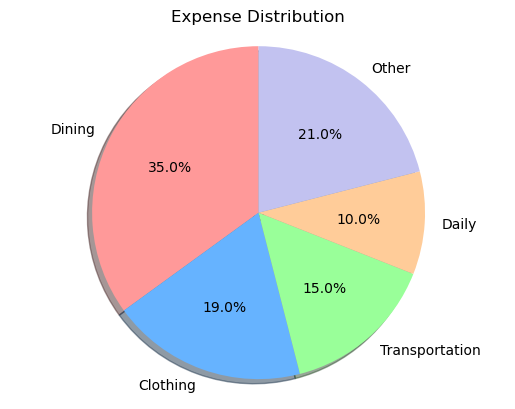

In [1]:
import matplotlib.pyplot as plt

# 数据
categories = ['Dining', 'Clothing', 'Transportation', 'Daily', 'Other']
expenses = [35, 19, 15, 10,21]
#expenses = [47, 18, 6, 10, 19]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

# 创建一个饼状图
fig, ax = plt.subplots()
ax.pie(expenses, labels=categories, autopct='%1.1f%%', startangle=90, colors=colors, shadow=True)

# 设置标题
plt.title('Expense Distribution')

# 显示饼状图
plt.axis('equal')  # 保持纵横比相等

fig.savefig("pipsummry.jpg", dpi = 300)
plt.show()
